In [ ]:
# hide
import sys
sys.path.append("..")

# Fast radiomics
Implementing a Radiomics workflow into fastai.

## Conventional Radiomics Workflow
Radiomics is a method where qunatitative features are extracted from medical images, which have the potential to allow conclusions to disease characterics not appreciated by a human observer.
A typical radiomics workflow usually consits out of several steps.

### 1. Image segmentation
Especially for radiomics analysis for cancer, the area of interest is maually segmented before the anlysis. An example is given below, where a T2w MRI sequence of the prostate has been segmented for the two different zones.
![pixelwise prostate segmentation](../img/prostate_segmentation.PNG)

### 2. Feature extraction
In a second step quantitative imaging features are extracted for each labeled region and usually stored in a table. 

### 3. Feature cleaning
Features are analyzed and highly correlationg features are usually excluded to reduce dimensionality of the data and redundancy of the features. 

### 4. Classification
Using the extracted features several machine learning models can be trained. 

## Challenges in Radiomics
Radiomics models are difficult to train and suffer from low generalizability on new data. The first challenge is accurate feature cleaning. Selecting the final features on the whole data, including the test dataset, likely leads to overfitting of the models. Instead features should only be extracted in the training dataset alone not on the validation or the test dataset. Also, there is a lack of augmentation strategies. Depending on the device used to aquire the medical image, imaging parameters (radiation dose, field strength, distance to device), reconstruction parameters and vendor specific post processig algorithms may differ and influene the pixel values. Using the conventional radiomics approach, this cannot be easily corrected for. 

## Proposed solution
Impleneting feature extraction into a fastai callback could help slove the above mentioned issues, as before each training epoch images can be normalized and augmented and even feature selection can be repeated mutliple times. Leading to am overall more robust approach.

In [ ]:
from faimed3d.basics import *
from faimed3d.data import *
from faimed3d.augment import *

from fastai.basics import *
from fastai.vision.augment import *

from radiomics import featureextractor
import SimpleITK as sitk

import logging
# set level for all classes
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)

In [ ]:
torch.cuda.set_device(1)

In [ ]:
prostate = pd.read_csv('../../dl-prostate-mapping/data/prostata-train.csv', sep = ',')[['t2_cropped_dcm', 't1_cropped_dcm','adc_cropped_dcm', 'adc_mask_cropped', 't2_mask_cropped', 't1_mask_cropped', 'ProstataCaHisto', 'is_valid']]

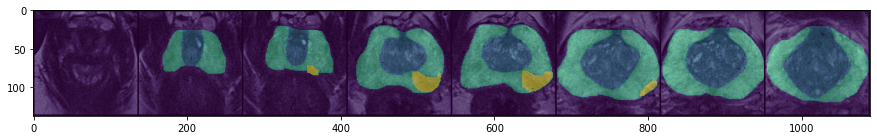

In [ ]:
im = TensorDicom3D.create(prostate.t2_cropped_dcm[105])
mask = TensorMask3D.create(prostate.t2_mask_cropped[105])
im.show()
mask.show(add_to_existing=True, alpha = 0.5, cmap = 'viridis')

In [ ]:
prostate = prostate.dropna(0)

In [ ]:
def IdentityBlock(): 
    "does not change input"
    return TransformBlock()

In [ ]:
mris = DataBlock(
    blocks = (ImageBlock3D(cls=TensorDicom3D), 
              ImageBlock3D(cls=TensorDicom3D), 
              ImageBlock3D(cls=TensorDicom3D), 
              MaskBlock3D(cls=TensorMask3D),
              MaskBlock3D(cls=TensorMask3D), 
              MaskBlock3D(cls=TensorMask3D), 
              IdentityBlock(),
              IdentityBlock(),
              IdentityBlock(),
              CategoryBlock()),
    get_x = [lambda x: x[0], lambda x: x[1], lambda x: x[2], lambda x: x[3], lambda x: x[4], lambda x: x[5], lambda x: x[0], lambda x: x[1], lambda x: x[2]],
    get_y = lambda x: x[7],
    item_tfms=[Pad3D((15, 200,200)), ClampMask3D],
    batch_tfms=[RandomContrast3D(p=.2), RandomBrightness3D(p=.2), RandomNoise3D(p=.2)],
    n_inp = 9)

In [ ]:
dls = mris.dataloaders(prostate, 
                       bs = 16)

In [ ]:
class ImageToFeatures(Callback):
    "Extracts Radiomics Features from image batch"
    def __init__(self, feature_extractor):
        store_attr() # extractor = featureextractor.RadiomicsFeatureExtractor()        
    
    def before_batch(self):
        n = len(self.learn.xb)//3
        images = self.learn.xb[0:n]  
        masks = self.learn.xb[n:n*2]  
        paths = detuplify(self.learn.xb[n*2:])
        
        images = torch.unbind(torch.stack(images, 1), 0)
        masks = torch.unbind(torch.stack(masks, 1), 0)
        paths = [p for p in zip(*paths)] # turns n_channels x batchsize to batchsize x n_channels
        
        features = [self.extract_item(im, mask, path) for im, mask, path in zip(images, masks, paths)]
        self.learn.xb = (torch.stack(features, 0), )
    
    def extract_item(self, images, masks, paths):
        "image of shape C x D x H x W"
        images = torch.unbind(images, dim = 0) 
        masks = torch.unbind(masks, dim = 0)      
        features = [self.extract_single(im, mask, path) for im, mask, path in zip(images, masks, paths)]
        features = torch.cat(features, dim = 0)
        return features
        
    def extract_single(self, im, mask, path):
        sitk_im = self.as_sitk(self.restore_metadata(im, path))
        sitk_ma = self.as_sitk(self.restore_metadata(mask, path)) # spacing mask and image should be identical
        result = self.feature_extractor.execute(sitk_im, sitk_ma)

        for k in list(result.keys()):
            if k.startswith('diagnostics'):
                del result[k]

        features = [float(result[key]) for key in result]
        return tensor(features).to(im.device)
    
    def restore_metadata(self, im, path):
        meta = TensorDicom3D.create(path).metadata
        im.metadata = meta
        return im
    
    def as_sitk(self, t):
        "convertes Tensor to SimpleITK image"
        im = sitk.GetImageFromArray(t.detach().cpu().numpy())
       # also save metadata        
        im.SetSpacing(t.metadata['spacing'])
        im.SetDirection(t.metadata['direction'])
        im.SetOrigin(t.metadata['origin'])
        for i in range(0, len(t.metadata['table'])):
            try:
                im.SetMetaData(t.metadata['table'].iloc[i,0], t.metadata['table'].iloc[i,1])
            except:
                pass
        return im

In [ ]:
class SimpleModel(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(SimpleModel, self).__init__()
        self.layer1 = self.make_layer(in_feat, 256)
        self.layer2 = self.make_layer(256, 128)
        self.out = nn.Linear(128, out_feat)
        
    def make_layer(self, in_channels, out_channels):
        layer = nn.Sequential(
                    nn.BatchNorm1d(in_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False),
                    nn.Linear(in_channels, out_channels, bias = False),
                    nn.ReLU(inplace=True)
                    )
        return layer
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.out(x)
        return x

In [ ]:
def loss(y_hat, y):
    return nn.BCEWithLogitsLoss()(y_hat.flatten(), y.float())
    

In [ ]:
feature_extractor = featureextractor.RadiomicsFeatureExtractor()
learn = Learner(dls, 
                SimpleModel(107*3, 1),
                opt_func = SGD, 
                loss_func = loss, 
                cbs = ImageToFeatures(feature_extractor))

In [ ]:
learn.fit_one_cycle(10, 0.1)

epoch,train_loss,valid_loss,time
0,0.659893,0.651459,04:51
1,0.657429,0.648664,04:59
2,0.654365,0.644531,15:46
3,0.653633,0.640212,04:42
4,0.647112,0.636824,15:29
5,0.645342,0.633964,04:49
6,0.641187,0.632039,18:07
7,0.639696,0.630806,21:40
8,0.636838,0.630294,21:20
9,0.635482,0.630220,17:41
